# Detecção de Fraudes em Pagamentos Online (Machine Learning)


![](Fraud_Cover.jpg)

# Visão geral


Este notebook apresenta um projeto ponta-a-ponta de **detecção de fraudes financeiras** usando *machine learning* sobre o dataset **PaySim** (transações simuladas).  
O foco aqui é **qualidade de portfólio**: reprodutibilidade, métricas adequadas para dados desbalanceados e narrativa clara.

**Conteúdo**
- Contexto e objetivos
- Carregamento e inspeção dos dados
- Pré-processamento e *feature set* utilizado
- Visualizações rápidas (EDA)
- Treinamento de modelo baseline
- **Cross-Validation**
- **Predições no conjunto de teste**
- **Predições no conjunto de validação**
- **Conclusão e próximos passos**


# Introduction

## Contexto

Fraudes em pagamentos são eventos raros, porém com **alto impacto**. Em problemas reais, dados financeiros tendem a ser privados e difíceis de compartilhar; por isso, este projeto usa o **PaySim**, um dataset público de transações simuladas inspirado em padrões do mundo real.

Do ponto de vista de modelagem, esse é um problema clássico de **classificação binária desbalanceada**: a classe *fraude* é uma fração pequena do total.  
Assim, **acurácia isolada não é suficiente** — priorizamos métricas como *precision*, *recall*, *F1*, **PR-AUC** e análise de limiar (*threshold*), pois o custo de falso negativo (fraude não detectada) costuma ser alto.


# Goals

**Objetivos do projeto**

1. Construir um pipeline simples e reprodutível para detecção de fraude.
2. Definir um *baseline* e avaliar com métricas apropriadas para desbalanceamento (**PR-AUC**, *recall*, matriz de confusão).
3. Comparar desempenho via **cross-validation** no treino.
4. Gerar predições e relatório no **teste** (generalização) e na **validação** (apoio à seleção/ajuste de limiar).
5. Documentar limitações e próximos passos para um cenário de produção.


# Imports and Data Load

In [7]:
# Imports (mantidos mínimos para reprodutibilidade)
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.tree import DecisionTreeClassifier


In [8]:
# Leitura do dataset
# Sugestão para portfólio: coloque o CSV em uma pasta ./data e versiona o notebook no GitHub.
DATA_PATH = "D://Data_science//data_science_DADOS//Fraud_Detection_data//PS_20174392719_1491204439457_log.csv"

raw_data = pd.read_csv(DATA_PATH)
raw_data.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Preprocessing

In [9]:
# Data Info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
# describe data rounding values
round(raw_data.describe(),2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [11]:
#Null data?
raw_data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
#Verificar os tipos de transações feitas e de quanto foi
raw_data.type.value_counts()


CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [14]:
# Correlação (linear) das features numéricas com o alvo `isFraud`
# Obs.: correlação é apenas um sinal preliminar; não implica causalidade.
corr = raw_data.corr()

corr["isFraud"].sort_values(ascending=False)


isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [15]:
# Codificação simples da feature categórica `type`
# (Para um portfólio mais robusto, o ideal é usar One-Hot Encoding; aqui mantemos um baseline simples.)

raw_data["type_raw"] = raw_data["type"]  # preserva valor original para EDA/visualizações

type_map = {
    "CASH_OUT": 1,
    "CASH_IN": 2,
    "PAYMENT": 3,
    "TRANSFER": 4,
    "DEBIT": 5,
}

raw_data["type"] = raw_data["type"].map(type_map).astype(int)

raw_data[["type_raw", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "isFraud"]].head()


,type_raw,type,amount,oldbalanceOrg,newbalanceOrig,isFraud
0,PAYMENT,3,9839.64,170136.0,160296.36,0
1,PAYMENT,3,1864.28,21249.0,19384.72,0
2,TRANSFER,4,181.00,181.0,0.00,1
3,CASH_OUT,1,181.00,181.0,0.00,1
4,PAYMENT,3,11668.14,41554.0,29885.86,0


# Construção dos conjuntos de treino/validação/teste

Para evitar *data leakage* e medir **generalização**, separamos os dados em:

- **Treino (train):** usado para ajustar os parâmetros do modelo
- **Validação (val):** usado para comparar alternativas e ajustar limiar (*threshold*)
- **Teste (test):** usado **uma única vez** para estimar desempenho final

> Usamos **split estratificado** para manter a proporção de fraudes em cada conjunto.


In [16]:
# Seleção de features e target
FEATURES = ["type", "amount", "oldbalanceOrg", "newbalanceOrig"]
TARGET = "isFraud"

X = raw_data[FEATURES].copy()
y = raw_data[TARGET].astype(int).values

# 1) Teste hold-out (10%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=26,
    stratify=y
)

# 2) Validação (20% do trainval => 18% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,
    random_state=26,
    stratify=y_trainval
)

print("Tamanhos:", {k: v.shape[0] for k, v in {"train": X_train, "val": X_val, "test": X_test}.items()})
print("Taxa de fraude (%):", {
    "train": 100*y_train.mean(),
    "val": 100*y_val.mean(),
    "test": 100*y_test.mean()
})


Tamanhos: {'train': 4581086, 'val': 1145272, 'test': 636262}
Taxa de fraude (%): {'train': 0.1290960265753579, 'val': 0.12905231246376409, 'test': 0.12903489443028188}


# Data Visualization

In [17]:
# Distribuição dos tipos de transação (EDA rápida)
type_counts = raw_data["type_raw"].value_counts()

import plotly.express as px
fig = px.bar(
    type_counts,
    title="Distribuição do tipo de transação",
    labels={"index": "tipo", "value": "contagem"}
)
fig.show()


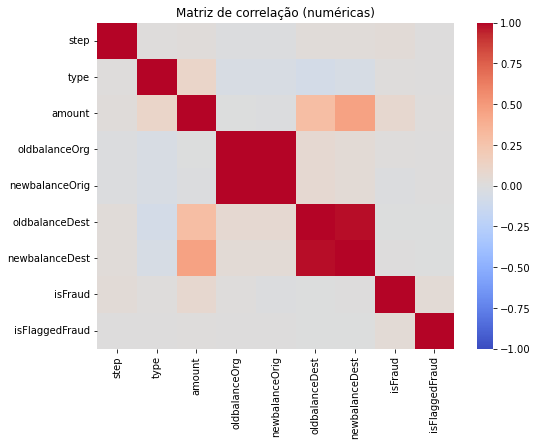

In [19]:
# Heatmap de correlação (apenas colunas numéricas)
corr = raw_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Matriz de correlação (numéricas)")
plt.show()


# Machine Learning Models & Training Set

In [20]:
# Preparando matrizes (mantemos também em numpy para compatibilidade com alguns modelos)
X_np = X.values
y_np = y

print("Shape X:", X_np.shape)
print("Shape y:", y_np.shape)


Shape X: (6362620, 4)
Shape y: (6362620,)


In [21]:
# Modelo baseline: Decision Tree (simples, interpretável e rápido)
# Em dados desbalanceados, usamos class_weight="balanced" para reduzir viés à classe majoritária.

model = DecisionTreeClassifier(
    random_state=26,
    class_weight="balanced",
    max_depth=6  # hiperparâmetro moderado para evitar overfitting grosseiro
)

model.fit(X_train, y_train)

# Avaliação rápida no conjunto de validação (aqui sem ajuste de limiar)
val_pred = model.predict(X_val)
val_proba = model.predict_proba(X_val)[:, 1]

print("Relatório (validação):")
print(classification_report(y_val, val_pred, digits=4))

print("ROC-AUC (val):", roc_auc_score(y_val, val_proba))
print("PR-AUC / Average Precision (val):", average_precision_score(y_val, val_proba))


Relatório (validação):
              precision    recall  f1-score   support

           0     1.0000    0.9728    0.9862   1143794
           1     0.0451    0.9953    0.0863      1478

    accuracy                         0.9728   1145272
   macro avg     0.5225    0.9840    0.5362   1145272
weighted avg     0.9988    0.9728    0.9850   1145272

ROC-AUC (val): 0.9955275700295427
PR-AUC / Average Precision (val): 0.4216582891522393


In [22]:
# Exemplos de predição (amostrando algumas transações do teste)
rng = np.random.default_rng(26)
idxs = rng.choice(len(X_test), size=5, replace=False)

sample = X_test.iloc[idxs].copy()
proba = model.predict_proba(sample)[:, 1]
pred = (proba >= 0.5).astype(int)

out = sample.copy()
out["proba_fraude"] = proba
out["predicao"] = pred
out["y_real"] = y_test[idxs]

out


,type,amount,oldbalanceOrg,newbalanceOrig,proba_fraude,predicao,y_real
2419414,2,15584.44,27276965.88,27292550.32,0.0,0,0
6063514,2,265909.37,4729390.84,4995300.21,0.0,0,0
977922,1,27039.44,70899.00,43859.56,0.0,0,0
1213348,3,32023.96,10289.00,0.00,0.0,0,0
739411,3,22395.22,0.00,0.00,0.0,0,0


# Cross-Validation

A seguir avaliamos o desempenho via **cross-validation estratificada** apenas no conjunto de **treino**.  
Isso reduz a dependência de um único split e fornece uma estimativa mais estável do desempenho esperado.

Métricas reportadas:
- **ROC-AUC**: capacidade de separação global
- **PR-AUC (Average Precision)**: mais informativa em classes raras
- **F1**: equilíbrio entre *precision* e *recall* para um limiar padrão (0.5)


In [24]:
# Cross-validation (StratifiedKFold)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=26)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}

cv = cross_validate(
    model,
    X_train,
    y_train,
    cv=skf,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

def _mean_std(x):
    return float(np.mean(x)), float(np.std(x))

summary = {k.replace("test_", ""): _mean_std(v) for k, v in cv.items() if k.startswith("test_")}
pd.DataFrame(
    {m: {"mean": summary[m][0], "std": summary[m][1]} for m in summary}
).T.sort_index()


,mean,std
f1,0.089117,0.004634
pr_auc,0.440880,0.022357
precision,0.046656,0.002546
recall,0.994084,0.003136
roc_auc,0.994927,0.001419


# Test Set Predictions

Aqui avaliamos o modelo no **conjunto de teste** (hold-out), que não foi usado nem para treinar nem para ajustar limiar.  
É a melhor aproximação do desempenho em dados “novos”.

Além do relatório de classificação, incluímos:
- Matriz de confusão
- ROC e Curva Precisão-Recall
- Métricas (ROC-AUC e PR-AUC)


Relatório (teste):
              precision    recall  f1-score   support

           0     1.0000    0.9729    0.9862    635441
           1     0.0453    0.9951    0.0866       821

    accuracy                         0.9729    636262
   macro avg     0.5226    0.9840    0.5364    636262
weighted avg     0.9988    0.9729    0.9851    636262



,Pred: Não fraude,Pred: Fraude
Real: Não fraude,618205,17236
Real: Fraude,4,817


ROC-AUC (teste): 0.995189495614199
PR-AUC / Average Precision (teste): 0.4773954776189593


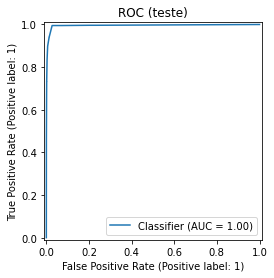

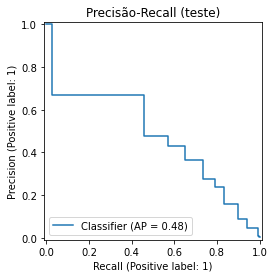

In [25]:
# Predições no teste
test_pred = model.predict(X_test)
test_proba = model.predict_proba(X_test)[:, 1]

print("Relatório (teste):")
print(classification_report(y_test, test_pred, digits=4))

cm = confusion_matrix(y_test, test_pred)
cm_df = pd.DataFrame(cm, index=["Real: Não fraude", "Real: Fraude"], columns=["Pred: Não fraude", "Pred: Fraude"])
display(cm_df)

print("ROC-AUC (teste):", roc_auc_score(y_test, test_proba))
print("PR-AUC / Average Precision (teste):", average_precision_score(y_test, test_proba))

# Curvas
RocCurveDisplay.from_predictions(y_test, test_proba)
plt.title("ROC (teste)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, test_proba)
plt.title("Precisão-Recall (teste)")
plt.show()


# Validation Set Predictions

Nesta seção usamos a **validação** para algo comum em fraudes: escolher um **limiar (threshold)** diferente de 0.5.  
Exemplo: às vezes aceitamos mais falsos positivos para **aumentar recall** (capturar mais fraudes).

Abaixo fazemos uma varredura simples de thresholds e mostramos um ponto de operação recomendado.


In [26]:
# Ajuste simples de threshold na validação
val_proba = model.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    pred_t = (val_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, pred_t).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
    rows.append({"threshold": t, "precision": precision, "recall": recall, "f1": f1, "fp": fp, "fn": fn})

thr_df = pd.DataFrame(rows)

# Critério simples: maximizar F1 (ajuste conforme custo do negócio)
best = thr_df.loc[thr_df["f1"].idxmax()]
best_threshold = float(best["threshold"])

display(thr_df.sort_values("threshold"))
print("Melhor threshold (por F1 na validação):", best_threshold)
print(best)

# Relatório com threshold escolhido
val_pred_thr = (val_proba >= best_threshold).astype(int)
print(classification_report(y_val, val_pred_thr, digits=4))

cm = confusion_matrix(y_val, val_pred_thr)
pd.DataFrame(cm, index=["Real: Não fraude", "Real: Fraude"], columns=["Pred: Não fraude", "Pred: Fraude"])


,threshold,precision,recall,f1,fp,fn
0,0.05,0.045092,0.995264,0.086276,31151,7
1,0.10,0.045092,0.995264,0.086276,31151,7
2,0.15,0.045092,0.995264,0.086276,31151,7
3,0.20,0.045092,0.995264,0.086276,31151,7
4,0.25,0.045092,0.995264,0.086276,31151,7
5,0.30,0.045092,0.995264,0.086276,31151,7
6,0.35,0.045092,0.995264,0.086276,31151,7
7,0.40,0.045092,0.995264,0.086276,31151,7
8,0.45,0.045092,0.995264,0.086276,31151,7
9,0.50,0.045092,0.995264,0.086276,31151,7


Melhor threshold (por F1 na validação): 0.95
threshold       0.950000
precision       0.156561
recall          0.882273
f1              0.265932
fp           7025.000000
fn            174.000000
Name: 18, dtype: float64
              precision    recall  f1-score   support

           0     0.9998    0.9939    0.9968   1143794
           1     0.1566    0.8823    0.2659      1478

    accuracy                         0.9937   1145272
   macro avg     0.5782    0.9381    0.6314   1145272
weighted avg     0.9988    0.9937    0.9959   1145272



,Pred: Não fraude,Pred: Fraude
Real: Não fraude,1136769,7025
Real: Fraude,174,1304


# Conclusion

**Resumo do que foi feito**

- Pré-processamento mínimo e definição de um *feature set* enxuto.
- Treinamento de um modelo baseline (Decision Tree) com ajuste para desbalanceamento.
- Avaliação com **cross-validation** no treino e métricas adequadas (ROC-AUC e principalmente **PR-AUC**).
- Relatórios no **teste** e análise de **threshold** na validação.

**Interpretação prática**

Em detecção de fraude, o objetivo costuma ser **maximizar recall** sem explodir falsos positivos.  
O passo de *thresholding* na validação mostra como mover o ponto de operação conforme o custo do negócio.

**Limitações deste baseline**

- A codificação numérica do `type` é uma simplificação (o ideal é *one-hot encoding*).
- Usamos poucas features; o dataset permite enriquecer com variáveis de saldo/destino e relações temporais.
- Não tratamos *drift* temporal nem validação por tempo (*time-based split*), comum em transações reais.


# Future Work

**Próximos passos (para elevar o nível de produção)**

1. **Pré-processamento robusto**
   - One-hot encoding do `type`
   - Padronização/normalização quando fizer sentido
   - Tratamento de outliers e *sanity checks*

2. **Modelos e *tuning***
   - Logistic Regression (baseline linear), Random Forest, Gradient Boosting (e.g., XGBoost/LightGBM)
   - Busca de hiperparâmetros (Grid/Random/Optuna) e validação estratificada

3. **Otimização por custo**
   - Definir função de custo (FN vs FP) e selecionar threshold orientado ao negócio
   - Métricas por faixa de risco e análise de *top-k* (ex.: investigar top 0.5% mais suspeitos)

4. **Explicabilidade e monitoramento**
   - Feature importance / SHAP
   - Monitorar *drift*, recalibrar e re-treinar periodicamente

5. **Deploy**
   - Pipeline serializável (sklearn Pipeline), versionamento de dados/modelo (MLflow/DVC)
   - API (FastAPI) + logging e observabilidade


# Obrigado! 👋


**Contato**
- LinkedIn: https://www.linkedin.com/in/fernandomarciano/
- (Opcional) GitHub: adicione aqui o repositório do projeto
